In [1]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import os
from os.path import isfile, join
import pandas as pd
from math import ceil
%matplotlib inline

Using TensorFlow backend.


In [2]:
master_image_size = 256, 256
master_color_channels = 1
random.seed(0)
base_image_dir = 'grayscale_molecules'

In [3]:
def get_new_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(master_image_size[0], master_image_size[1], master_color_channels)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=0.5e-4), metrics=['acc'])
    return model

In [4]:
def train_validation_test(base_path, train_fraction=0.8, shuffle_seed=0):
    """
    Reads images in a directory and splits them up according to class
    
    Assumes a binary classification, with EQUAL COUNTS in each
    class.
    """
    random.seed(shuffle_seed)
    
    all_images_list = []
    
    for filename in os.listdir(base_path):
        if isfile(join(base_path, filename)):
            image_class = filename.split('.')[0]
            all_images_list.append({'class': image_class, 'filename': filename})
    
    all_images = pd.DataFrame(all_images_list)
    all_images = all_images.sample(frac=1).reset_index(drop=True)
    all_classes = all_images['class'].unique()
    
    first_class_name = all_classes[0]
    second_class_name = all_classes[1]
    
    first_class = all_images.copy().where(all_images['class'] == first_class_name).dropna()
    second_class = all_images.copy().where(all_images['class'] == second_class_name).dropna()

    train_row_count = int(len(first_class) * train_fraction)
    test_val_count = len(first_class) - train_row_count
    
    first_class_train = first_class.iloc[2 * test_val_count:]
    first_class_val = first_class.iloc[test_val_count:2 * test_val_count]
    first_class_test = first_class.iloc[0:test_val_count]
    
    second_class_train = second_class.iloc[2 * test_val_count:]
    second_class_val = second_class.iloc[test_val_count:2 * test_val_count]
    second_class_test = second_class.iloc[0:test_val_count]
    
    train = first_class_train.append(second_class_train).reset_index().drop('index', axis=1)
    val = first_class_val.append(second_class_val).reset_index().drop('index', axis=1)
    test = first_class_test.append(second_class_test).reset_index().drop('index', axis=1)
    
    return train, val, test

In [5]:
def train_validation_test_generators(src_dir, train_fraction=0.8, shuffle_seed=0):
    train, validation, test = train_validation_test(src_dir, train_fraction, shuffle_seed)

    train_datagen = image.ImageDataGenerator(rescale=1.0/255)
    test_datagen = image.ImageDataGenerator(rescale=1.0/255)
    validation_datagen = image.ImageDataGenerator(rescale=1.0/255)

    train_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                        directory=src_dir,
                                                        target_size=master_image_size,
                                                        batch_size=20,
                                                        shuffle=False,
                                                        color_mode='grayscale',
                                                        class_mode='binary')

    validation_generator = train_datagen.flow_from_dataframe(dataframe=validation,
                                                      directory=src_dir,
                                                      target_size=master_image_size,
                                                      batch_size=20,
                                                      shuffle=False,
                                                      color_mode='grayscale',
                                                      class_mode='binary')

    test_generator = train_datagen.flow_from_dataframe(dataframe=test,
                                                       directory=src_dir,
                                                       target_size=master_image_size,
                                                       batch_size=20,
                                                       shuffle=False,
                                                       color_mode='grayscale',
                                                       class_mode='binary')
    
    return train_generator, validation_generator, test_generator

In [6]:
train_generator, validation_generator, test_generator = train_validation_test_generators(base_image_dir)

model = get_new_model()

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=50)

Found 118 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
100/100 [==============================] - 13s 133ms/step - loss: 0.7130 - acc: 0.4165 - val_loss: 0.6889 - val_acc: 0.7000
Epoch 2/10
100/100 [==============================] - 10s 100ms/step - loss: 0.6442 - acc: 0.7009 - val_loss: 0.5999 - val_acc: 0.7250
Epoch 3/10
100/100 [==============================] - 10s 100ms/step - loss: 0.4513 - acc: 0.8175 - val_loss: 0.5815 - val_acc: 0.7000
Epoch 4/10
100/100 [==============================] - 10s 101ms/step - loss: 0.2082 - acc: 0.9230 - val_loss: 0.6214 - val_acc: 0.7500
Epoch 5/10
100/100 [==============================] - 10s 101ms/step - loss: 0.0201 - acc: 0.9990 - val_loss: 1.0991 - val_acc: 0.7250
Epoch 6/10
100/100 [=======

In [7]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

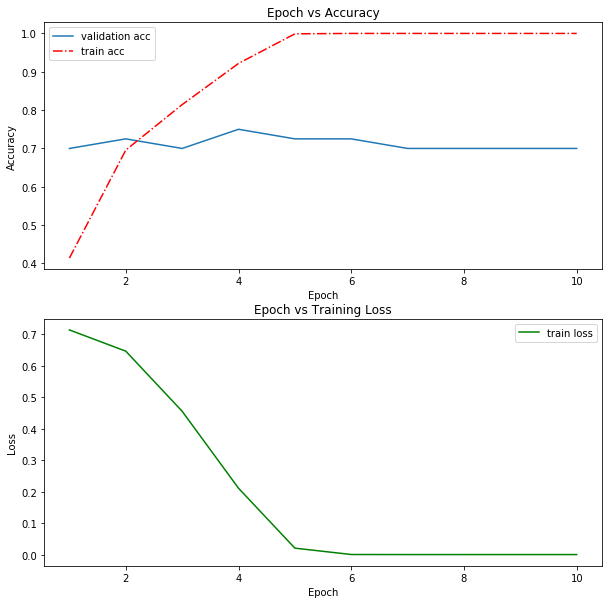

In [8]:
epochs = range(1, len(acc) + 1)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Epoch vs Accuracy')
axs[0].plot(epochs, val_acc, label='validation acc')
axs[0].plot(epochs, acc, 'r', ls='-.', label='train acc')
axs[0].legend()

axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Epoch vs Training Loss')
axs[1].plot(epochs, loss, 'g', label='train loss')
axs[1].legend()

In [9]:
print(f'Validation accuracy max at epoch {np.array(val_acc).argmax() + 1} is {max(val_acc)}')

Validation accuracy max at epoch 4 is 0.75


In [10]:
train_generator, validation_generator, test_generator = train_validation_test_generators(base_image_dir)

model = get_new_model()

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=4,
                              validation_data=validation_generator,
                              validation_steps=50)

Found 118 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.
Epoch 1/4
100/100 [==============================] - 10s 105ms/step - loss: 0.7131 - acc: 0.4260 - val_loss: 0.6890 - val_acc: 0.7000
Epoch 2/4
100/100 [==============================] - 10s 100ms/step - loss: 0.6451 - acc: 0.6944 - val_loss: 0.5981 - val_acc: 0.7250
Epoch 3/4
100/100 [==============================] - 10s 101ms/step - loss: 0.4460 - acc: 0.8155 - val_loss: 0.5811 - val_acc: 0.6750
Epoch 4/4
100/100 [==============================] - 10s 101ms/step - loss: 0.1926 - acc: 0.9295 - val_loss: 0.6464 - val_acc: 0.7500


In [11]:
def name_of_class_from_prediction_value(value):
    if value < 0.25:
        return 'ring'
    elif value > 0.75:
        return 'NO ring'
    else:
        return 'WTF?'

In [12]:
def read_images_from_df_and_classify(test_df, dirname, image_size, classifier):
    singles = []
    for filename in test_df['filename']:
        single = image.load_img(os.path.join(dirname, filename), target_size=image_size, color_mode='grayscale')
        single = image.img_to_array(single)
        single /= 255.0
        singles.append(single)
    batch = np.stack(singles, axis=0)
    predicted_classes = classifier.predict(batch)
    return singles, predicted_classes.flatten()

In [13]:
def classify_images_from_df_and_display(test_df, dirname, image_size, classifer):
    images, predicted_classes = read_images_from_df_and_classify(test_df, dirname, image_size, classifer)
    ncols = 4
    nrows = int(ceil(len(images) / ncols))
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 40))
    for image, predicted_class, ax in zip(images, predicted_classes, axs.reshape(-1)):
        title = name_of_class_from_prediction_value(predicted_class)
        ax.imshow(image.reshape(image_size), cmap='gray')
        ax.set_title(title)

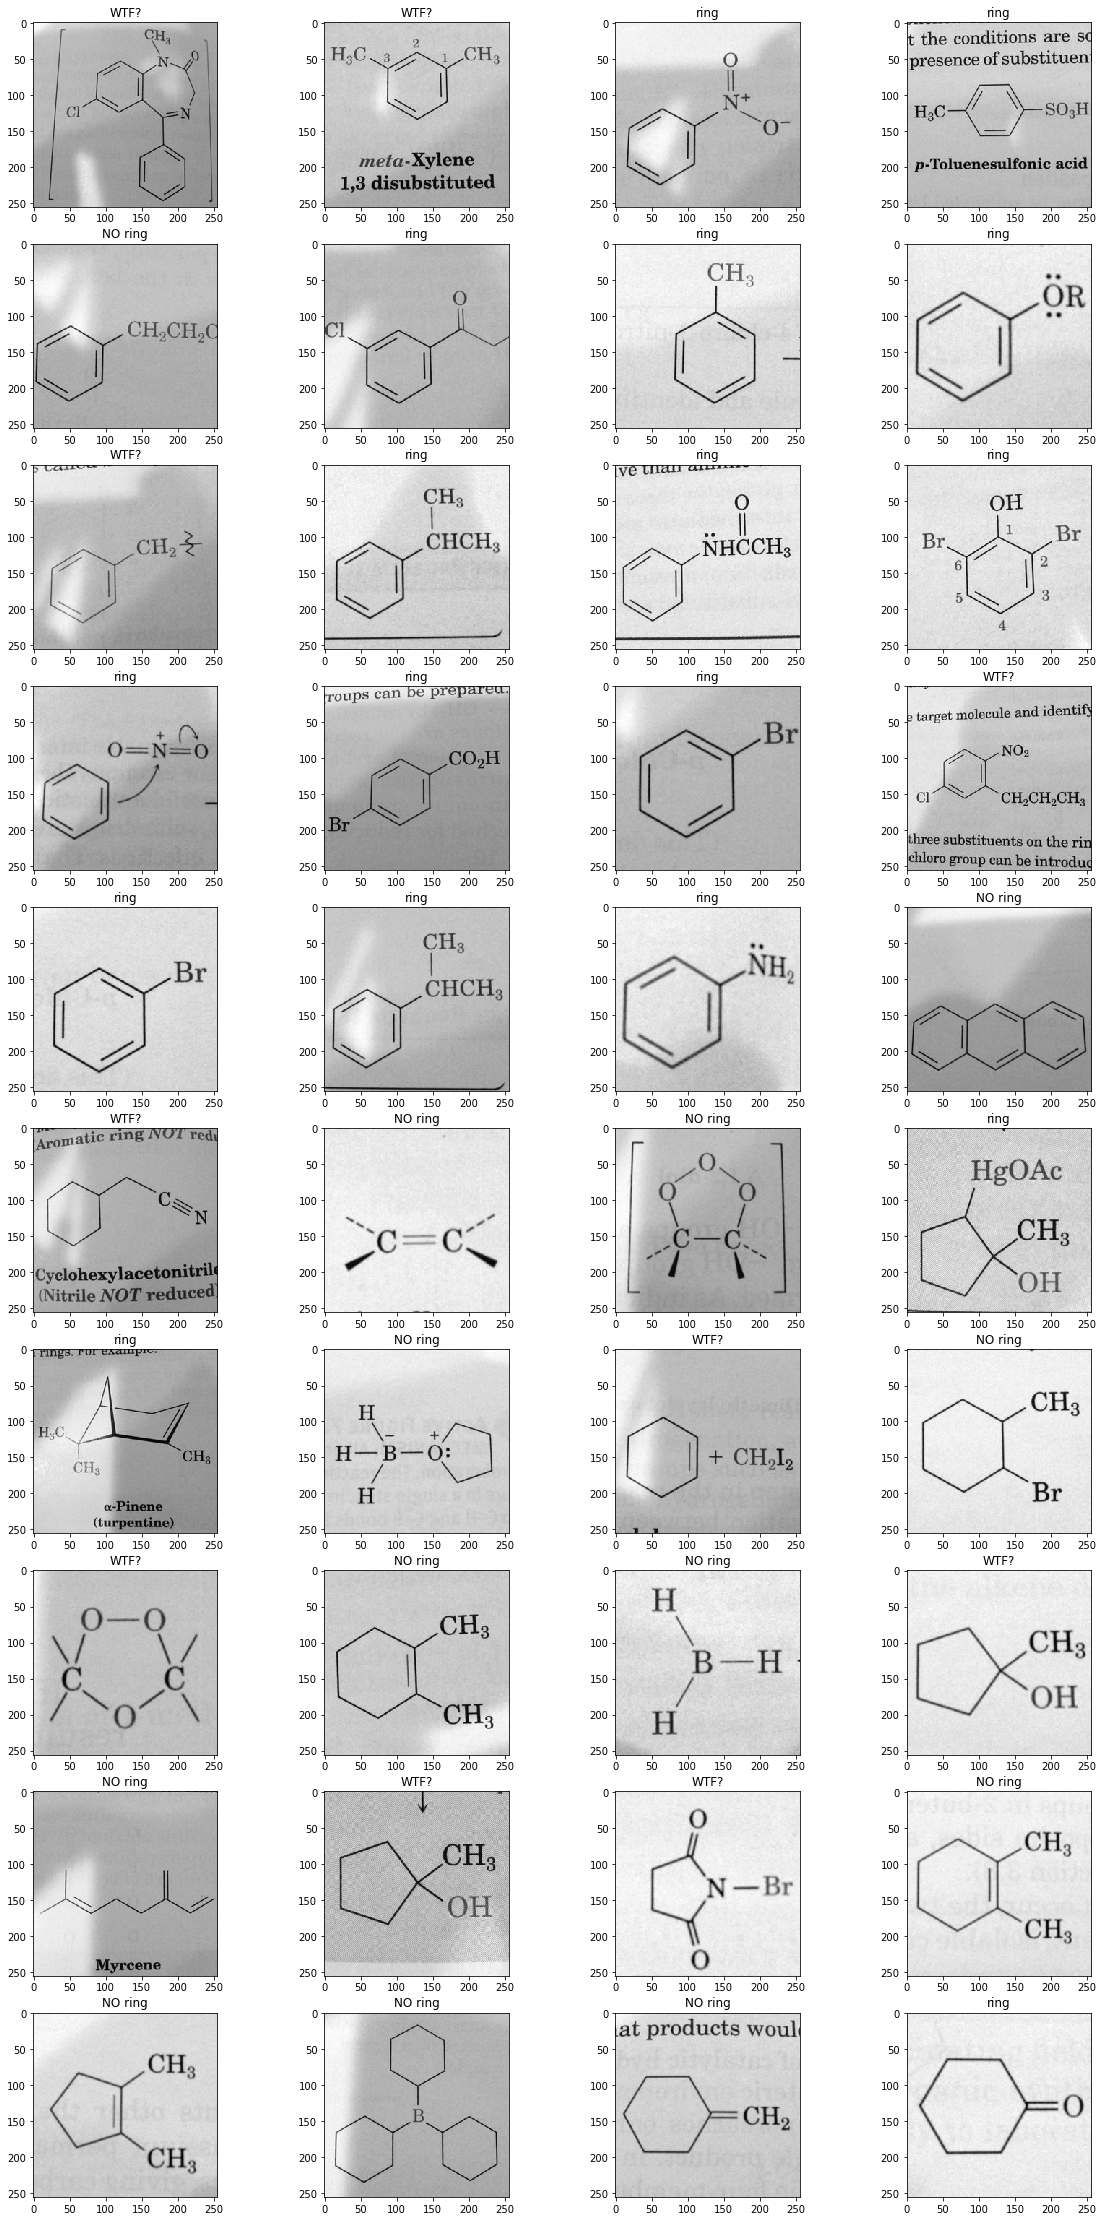

In [14]:
_, _, test = train_validation_test(base_image_dir)
classify_images_from_df_and_display(test, base_image_dir, master_image_size, model)